In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import tifffile
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import datetime
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
torch.backends.cudnn.benchmark = True

## Extracting the latent representation of all objects (N=371,012)
Be sure to match all Autoencoder and dataloader params below to match that used in the previous training (found in Training_notebook.py).

In [8]:
class Autoencoder(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            downsampling_factors,
            fmaps,
            fmul,
            kernel_size=3):

        super(Autoencoder, self).__init__()

        out_channels = in_channels

        encoder = []

        for downsampling_factor in downsampling_factors:

            encoder.append(
                    torch.nn.Conv2d(
                        in_channels,
                        fmaps,
                        kernel_size))
            encoder.append(
                    torch.nn.ReLU(inplace=True))
            encoder.append(
                    torch.nn.Conv2d(
                        fmaps,
                        fmaps,
                        kernel_size))
            encoder.append(
                    torch.nn.ReLU(inplace=True))
            encoder.append(
                    torch.nn.MaxPool2d(downsampling_factor))

            in_channels = fmaps

            fmaps = fmaps * fmul

        fmaps_bottle = fmaps

        encoder.append(
            torch.nn.Conv2d(
                in_channels,
                fmaps_bottle,
                kernel_size))
        encoder.append(
            torch.nn.ReLU(inplace=True))

        self.encoder = torch.nn.Sequential(*encoder)

        decoder = []

        fmaps = in_channels

        decoder.append(
            torch.nn.Conv2d(
                fmaps_bottle,
                fmaps,
                kernel_size))
        decoder.append(
            torch.nn.ReLU(inplace=True))

        for downsampling_factor in downsampling_factors[::-1]:

            fmaps = in_channels // fmul

            decoder.append(
                torch.nn.Upsample(
                    scale_factor=downsampling_factor,
                    mode='bilinear'))
            decoder.append(
                torch.nn.Conv2d(
                    in_channels,
                    fmaps,
                    kernel_size))
            decoder.append(
                torch.nn.ReLU(inplace=True))
            decoder.append(
                torch.nn.Conv2d(
                    fmaps,
                    fmaps,
                    kernel_size))
            decoder.append(
                torch.nn.ReLU(inplace=True))

            in_channels = fmaps

        decoder.append(
            torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size))

        self.decoder = torch.nn.Sequential(*decoder)

    def forward(self, x):

        enc = self.encoder(x)

        dec = self.decoder(enc)

        return enc, dec
        


In [3]:
# For using the GPU 
assert torch.cuda.is_available()
device = torch.device("cuda")
model_depth = 1
downsampling_factor = 2

In [4]:
# Setting directories
root_dir = '/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/'

# Importing the model
model = Autoencoder(in_channels=1, downsampling_factors=[downsampling_factor]*model_depth, fmaps=32, fmul=2, kernel_size = 3).to(device)
state = torch.load(root_dir+'models/20230902-174201.pt')
model.load_state_dict(state, strict=True)

<All keys matched successfully>

In [5]:
# Getting the file names of raw and mask files
raw_files = sorted(glob(os.path.join(root_dir, 'cropped_rawfiles', '*.tif'))) 
mask_files = sorted(glob(os.path.join(root_dir, 'cropped_masks', '*.tif')))

In [6]:
# Looping the pre-trained model over the entire dataset: 

# make sure net is in eval mode so we don't backprop
model.eval()

for idx in tqdm(range(len(raw_files))): 
    # read in image 
    image = tifffile.imread(raw_files[idx])
    mask = tifffile.imread(mask_files[idx])
    # move image to device
    image = (image/65535.0) * mask
    image = image[np.newaxis, np.newaxis, ...]
    image = torch.from_numpy(image).float().to(device)
    latent,_ = model(image) # key line
    latent = latent.cpu().detach().numpy()
    
    filename = os.path.basename(raw_files[idx])
    tifffile.imwrite(os.path.join(root_dir, 'latent_spaces', filename), latent)

  0%|▏                                                                                        | 562/371012 [00:35<6:24:54, 16.04it/s]

KeyboardInterrupt



In [9]:
latent.dtype
latent.shape

(1, 64, 74, 74)

In [ ]:
# it is taking a while to save the latent spaces (6 hrs??) 
# Do we really need to store them as images? arrays are enough? 

## Representing the latent space with UMAP plotting
Question: do learned features cluster in potentially meaningful ways?

What we have: a directory of 371,012 latent representations of datatype float32 and shape (1, 64, 74, 74).

### Testing if things are installed correctly (the Penguin Test)
Previous to this, I had followed instructions to install this in the conda env 06_instance_segmentation (via Jupyter terminal).
See: https://umap-learn.readthedocs.io/en/latest/index.html

We need to install seaborn, umap, pandas, and make sure sklearn is version 1.3.0.


In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
%matplotlib inline

# needed to install umap, seaborn, pandas before running these cells

/home/evan/conda/envs/06_instance_segmentation/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


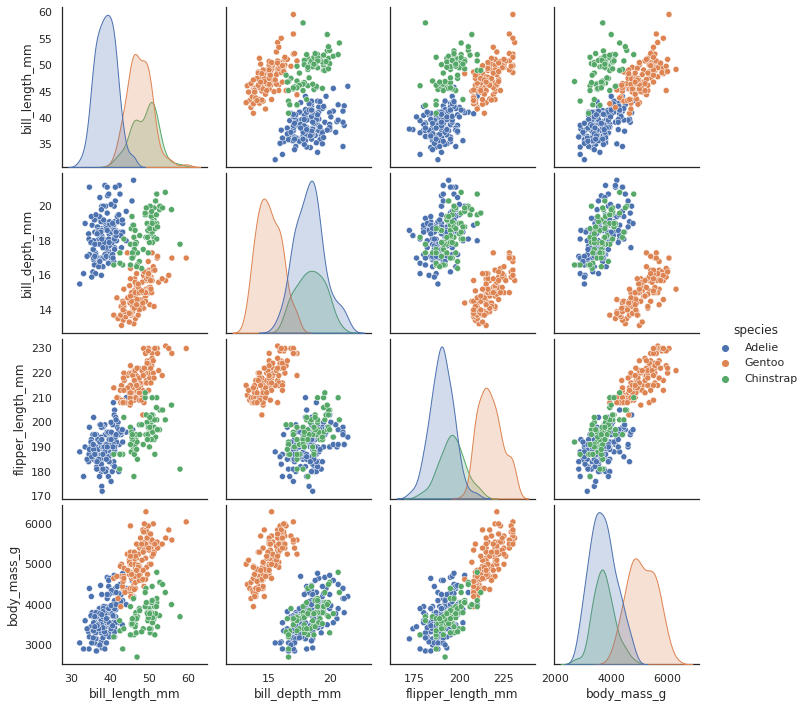

In [3]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

penguins = penguins.dropna()
penguins.species.value_counts()

sns.pairplot(penguins.drop("year", axis=1), hue='species');

In [7]:
# Check sklearn version number! if it is NOT 1.3.0, need to pip uninstall scikit-learn and pip install scikit-learn==1.3.0
import sklearn
print(sklearn.__version__)

1.3.0


In [8]:
from sklearn.metrics import DistanceMetric # needed to uninstall scikit-learn and  pip install scikit-learn==1.3.0 for this import to work
import umap

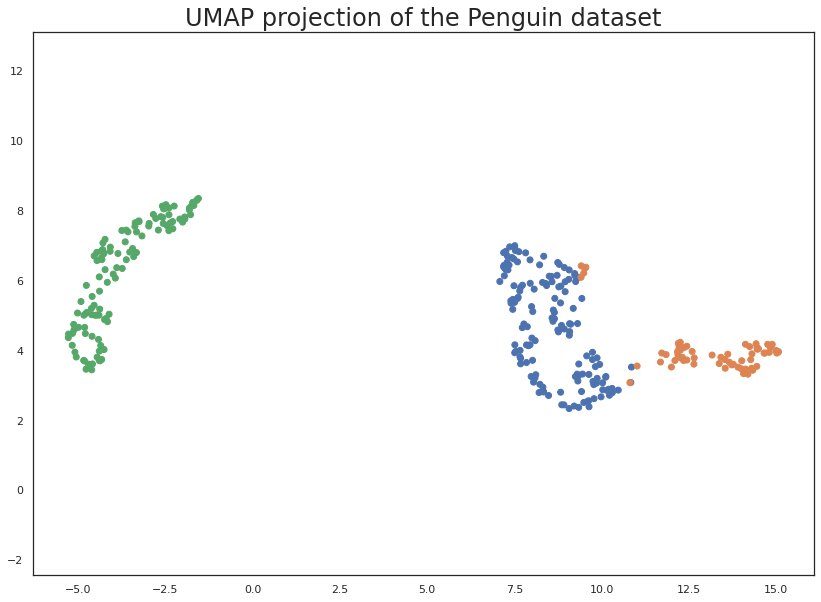

In [9]:
reducer = umap.UMAP()

penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of the Penguin dataset', fontsize=24);

### UMAP for our latent representations

In [59]:
import os
from glob import glob

In [60]:
# Importing test data (n=563)
latent_dir = '/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/latent_spaces/'
latent_files = sorted(glob(os.path.join(latent_dir, '*.tif')))
len(latent_files) # length is 563 as we expect

562

In [ ]:
# Finding a low dimensional representation of the data.
fit = umap.UMAP()
%time u = fit.fit_transform(data)

In [43]:
print(latent_files[1])
test_image = tifffile.imread(latent_files[0])
#test_image = test_image[1:]
#test_image.shape # (1, 64, 74, 74)
test_image = np.array(test_image)
test_image.shape
#test_image.dtype # float32

/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/latent_spaces/Tile00002_y968_x1222.tif


(1, 64, 74, 74)

In [62]:
latents = []

for image_file in latent_files:
    # read into image
    image = tifffile.imread(image_file)
    
    # Flatten each image into a 1D vector and stack them vertically
    reshaped_image = image.flatten()

    latents.append(reshaped_image)
    
latents = np.stack(latents) # 562 times number of features

In [63]:
fit = umap.UMAP()
u = fit.fit_transform(latents) 

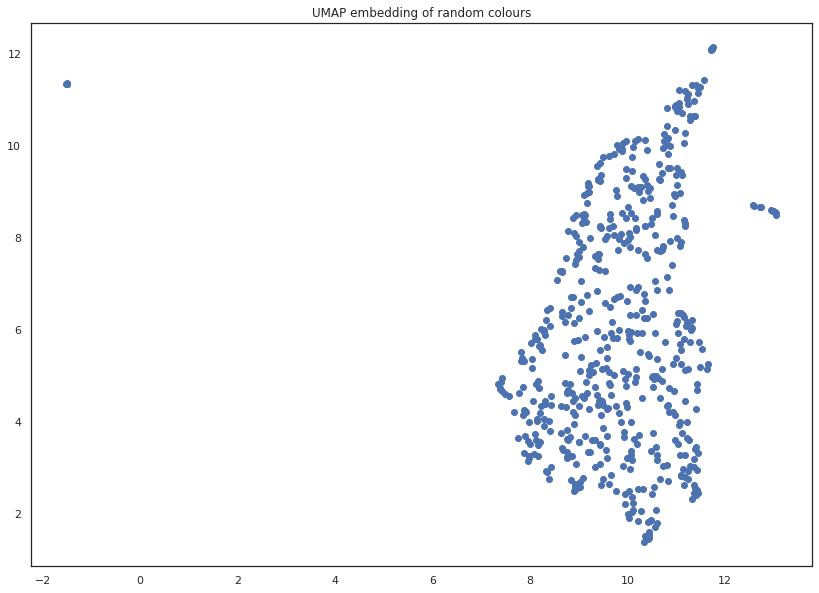

In [65]:
plt.scatter(u[:,0], u[:,1])
plt.title('UMAP embedding of random colours');